# The Analyses of Spark PRs with spaCy and Scikit-Learn 

This notebook was used to analyze the Spark commit messages and PRs with spaCy and Scikit-Learn. 

First, we extract the useful descriptions and comments from Spark issues (Section 1). 

Second, we use spaCy to do tokenization, remove stop words and reduce inflected words to their root stem (Section 2). 

Third, we use Scikit-Learn to analyze Spark issues: calculate the percentages of different kinds of words in all issues (Section 3.1), the TF-IDF of all issues (Section 3.2), the term frequency distributions (Section 3.3), the classification of all issues (Section 3.4) and the issue similarity matrix (Section 3.5).

## 0. Installation

If you use Linux-like system, (including, to greater or lesser degrees, Ubuntu, MacOS, Cygwin, and Bash for Windows), you should be able to run these commands to install SpaCy, Scikit-Learn, Pandas, and the other required libraries. Ete3 is a library for tree visualization which is optional.

    sudo pip install spacy scikit-learn pandas ete3

Now download the SpaCy data with this command:

    python -m spacy.en.download all

## 1. Extract the useful information from Spark issues

In [207]:
#coding=utf-8
import xml.dom.minidom
import re
import os

Remove some useless XML headers.

In [208]:
def remove(data):
    data = re.sub(r'</?p>', "", data)
    data = re.sub(r'</?tt>', "", data)
    data = re.sub(r'<br/>', "", data)
    data = re.sub(r'\<a.*?\>', "", data)
    data = re.sub(r'</a>', "", data)
    data = re.sub(r'\<div.*?\>', "", data)
    data = re.sub(r'\</div\>', "", data)
    data = re.sub(r'\<pre.*?\>', "", data)
    data = re.sub(r'\</pre\>', "", data)
    data = re.sub(r'\<span.*?\>', "", data)
    data = re.sub(r'\</span\>', "", data)
    data = re.sub(r'\<ul.*?\>', "", data)
    data = re.sub(r'</ul\>', "", data)
    data = re.sub(r'\<table.*?\>', "", data)
    data = re.sub(r'\</table\>', "", data)
    data = re.sub(r'\<td.*?\>', "", data)
    data = re.sub(r'\</td\>', "", data)
    data = re.sub(r'\<th.*?\>', "", data)
    data = re.sub(r'\</th\>', "", data)
    data = re.sub(r'\</?del\>', "", data)
    data = re.sub(r'\</?em\>', "", data)
    data = re.sub(r'\</?h3\>', "", data)
    data = re.sub(r'\</?li\>', "", data)
    data = re.sub(r'</?ol>', "", data)
    data = re.sub(r'</?tr>', "", data)
    data = re.sub(r'</?tbody>', "", data)
    data = re.sub(r'\<img.*?\>', "", data)
    data = re.sub(r'\n', " ", data)
    data = re.sub(r'\&gt\;', ">", data)
    data = re.sub(r'\&lt\;', "<", data)
    data = re.sub(r'\&\#91\;', "[", data)
    data = re.sub(r'\&\#93\;', "]", data)
    data = re.sub(r'\&\#8211\;', "-", data)
    data = re.sub(r'\&amp\;', "&", data)
    data = re.sub(r'\<200c\>', "", data)
    data = re.sub(r'\<200b\>', "", data)
    return data

Read titles, descriptions and comments from Spark issues.

In [209]:
def readInfoFromXML(root, toFile):
    fopen = open(toFile, 'w')
    title = root.getElementsByTagName('title')
    for i, ti in enumerate(title):
        if i != 0:
            data = ti.firstChild.data
            data = re.sub(r'\[.*?\]\s', "", data)
            data = remove(data)
            fopen.write('%s\n' % (data))
    description = root.getElementsByTagName('description')
    for i, des in enumerate(description):
        if i != 0 and des.firstChild != None:
            data = remove(des.firstChild.data)
            fopen.write('%s\n' % (data.encode('utf-8')))
    comments = root.getElementsByTagName('comment')
    for i, com in enumerate(comments):
        data = remove(com.firstChild.data)
        fopen.write('%s\n' % (data.encode('utf-8')))
    fopen.close()

Write the extracted information to new dir and files.

In [210]:
def getInfoFromXML(fromDir, path):
    toDir = "./data/desAndCom/"
    fromFile = os.path.join('%s%s' % (fromDir, path))
    toFile = os.path.join('%s%s' % (toDir, path))
    #print fromFile, toFile, path
    dom = xml.dom.minidom.parse(fromFile)
    root = dom.documentElement
    readInfoFromXML(root, toFile)

The file operations.

In [211]:
# Print all files of this dir 'filepath'
def eachFile(filepath):
    pathDir =  os.listdir(filepath)
    for allDir in pathDir:
        child = os.path.join('%s%s' % (filepath, allDir))
        print child.decode('gbk')

# Print the content of this file 'filename'
def readFile(filename):
    fopen = open(filename, 'r') 
    for eachLine in fopen:
        print "the content of this line", line
    fopen.close()

# Write multiple lines to a specific file
def writeFile(filename):
    fopen = open(filename, 'w')
    while True:
        aLine = raw_input()
        if aLine != ".":
            fopen.write('%s%s' % (aLine, os.linesep))
        else:
            print "the file is saved"
            break
    fopen.close()

Get all descriptions and comments for spaCy.

In [212]:
def getUsefulInfo(filepath):
    pathDir =  os.listdir(filepath)
    subName = "SPARK"               #now only extract from spark JRs
    invalidName = "invalid"
    for allDir in pathDir:
        if subName in allDir:
            if invalidName in allDir:
                continue
            getInfoFromXML(filepath, allDir)
            #print allDir

filePath = "./data/spark-issues/"
#eachFile(filePath)
getUsefulInfo(filePath)             #write all useful information to ./data/desAndCom

## 2. Use spaCy to do tokenization, stemming and remove stop words 

In [213]:
import spacy

This command will load the model of spaCy, which might take a little while.

In [214]:
 nlp = spacy.load('en-core-web-md')

Get all extracted files and print the number of files.

In [215]:
fileList =  os.listdir("./data/desAndCom/")
fileDir = "./data/desAndCom/"
files = []
for tempFile in fileList:
    if "ipynb" in tempFile:
        continue
    files.append(os.path.join('%s%s' % (fileDir, tempFile)))
print len(files)  

93


Parse the texts. These commands might take a little while. 

In [216]:
# Use spaCy to analysis these files
text_num = len(files)
text_array = [[]] * text_num
for i, tempFile in enumerate(files):
    raw_data = open(files[i]).read()
    text_array[i] = nlp(raw_data.decode('utf-8'))
#print files[0]
#print text_array[0]

In [217]:
# Just for checking
#for token in text_array[0]:
#    print (token, token.lemma_, token.lemma, token.pos_, token.pos, token.is_stop)

Each SpaCy document is already tokenized into words, which are accessible by iterating over the document. The next step just prints one text after removing stop words, punctuations, bracket, etc. Note capitals and steming will be dealt later.

In [218]:
for i, token in enumerate(text_array[0]):
    if token.is_punct or token.is_space or token.is_stop or token.pos_ == 'SYM':
        continue
    print (token, token.lemma_, token.lemma, token.pos_, token.pos, token.is_stop)

(Add, u'add', 1646, u'VERB', 98, False)
(methods, u'method', 2559, u'NOUN', 90, False)
(maintain, u'maintain', 3332, u'VERB', 98, False)
(singleton, u'singleton', 263228, u'NOUN', 90, False)
(StreamingContext, u'streamingcontext', 776981, u'PROPN', 94, False)
(REPL/notebook, u'repl/notebook', 776983, u'NOUN', 90, False)
(environment, u'environment', 2309, u'NOUN', 90, False)
(easy, u'easy', 1253, u'ADJ', 82, False)
(lose, u'lose', 1564, u'VERB', 98, False)
(reference, u'reference', 2358, u'NOUN', 90, False)
(StreamingContext, u'streamingcontext', 776981, u'PROPN', 94, False)
(overriding, u'override', 509640, u'VERB', 98, False)
(variable, u'variable', 7031, u'ADJ', 82, False)
(happen, u'happen', 1132, u'VERB', 98, False)
(execute, u'execute', 8879, u'VERB', 98, False)
(following, u'follow', 1933, u'VERB', 98, False)
(commands, u'command', 4341, u'NOUN', 90, False)
(val, u'val', 4995, u'NOUN', 90, False)
(ssc, u'ssc', 378797, u'NOUN', 90, False)
(new, u'new', 817, u'ADJ', 82, False)
(St

Write the intermediate results to files.

In [219]:
fileList = os.listdir("./data/desAndCom/")
fileDir = "./data/clearFiles/"
files = []
for tempFile in fileList:
    if "ipynb" in tempFile:
        continue
    files.append(os.path.join('%s%s' % (fileDir, tempFile)))

for j in range(text_num):
    fopen = open(files[j], 'w')
    for i, token in enumerate(text_array[j]):
        if token.is_punct or token.is_space or token.is_stop or token.pos_ == 'SYM':   #include symbor, such as "="
            continue
        fopen.write(token.lemma_.encode('utf8') + " ")   #reduce all words to its root stem
        #print token.lemma_
    fopen.close()

## 3. Use Scikit-Learn to analyze PRs and issues

In [220]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

from collections import Counter
from glob import glob
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline


Reload the clear files and use the spaCy models to analyze them.

In [221]:
text_num = len(files)
text_array = [] * text_num
for i, tempFile in enumerate(files):
    raw_data = open(files[i]).read()
    text_array.append(nlp(raw_data.decode('utf-8')))
#print files[0]
#print text_array[0]

### 3.1.  The percentage of different POS (Parts of Speech) in all issues

Each word already has a part of speech and a tag associated with it. It's fun to compare the distribution of parts of speech in all issues.

In [222]:
# Get the total number of all words
totalWords = 0
for i, tempFile in enumerate(files):
    totalWords += len(text_array[i])
#print totalWords

# Get the total number of different POS
totalType = {}
for i, tempFile in enumerate(files):
    typeMap = text_array[i].count_by(spacy.attrs.POS)
    for obj in typeMap.items():
        if obj[0] in totalType:
            totalType[obj[0]] += obj[1]
        else:
            totalType[obj[0]] = obj[1]

# Test
#for obj in totalType.items():       
#    print obj

The horizontal axis shows the parts of speech, and the vertical axis shows the percentage of different kinds of words. The noun, the adjective, the number and the verb account for the most proportion.

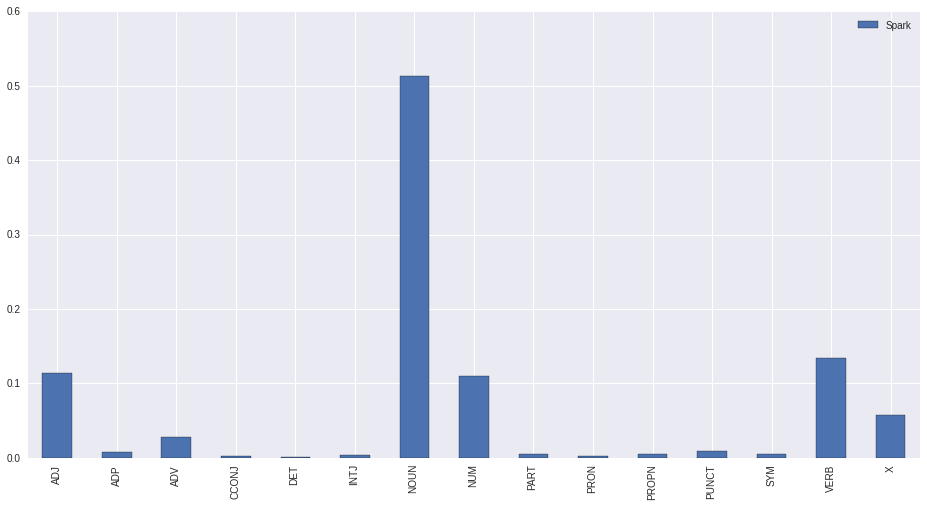

In [223]:
# Set the data of the figure
textPOS = [] 
textPOS.append(pd.Series(totalType) / totalWords)     # the sequence of POS percentages
#print textPOS

# Set the tag in the X axis
tagDict = {}
for i, tempFile in enumerate(files):
    for w in text_array[i]:
        tagDict[w.pos] = w.pos_

rcParams['figure.figsize'] = 16, 8
df = pd.DataFrame([textPOS[0]], index=['Spark'])                        # the figure configuration
df.columns = [tagDict[column] for column in df.columns]                 # the columns configuration
df.T.plot(kind='bar')

In [224]:
# Use the percentage of different POS in two issues to draw a picture
#textPOS = [] * text_num
#for i, tempFile in enumerate(files):
#    textPOS.append(pd.Series(text_array[i].count_by(spacy.attrs.POS))/len(text_array[i]))     # the sequence of POS percentages
#rcParams['figure.figsize'] = 16, 8
#df = pd.DataFrame([textPOS[0], textPOS[1]], index=['firstText', 'secondText'])  # the figure configuration
#df.columns = [tagDict[column] for column in df.columns]                 # the columns configuration
#df.T.plot(kind='bar')

### 3.2.  The TF-IDF of all documents

This uses a non-semantic technique for vectorizing documents, just using bag-of-words. We won't need any of the fancy features of SpaCy for this, just scikit-learn. We'll vectorize the corpus using scikit-learn's TfidfVectorizer class. This creates a matrix of word frequencies. 

In [225]:
# First, we'll vectorize the corpus using scikit-learn's TfidfVectorizer class.
tfidf = TfidfVectorizer(input='filename', decode_error='ignore', use_idf=True)

In [226]:
# While we're at it, let's make a list of the lengths, so we can use them to plot dot sizes. 
lengths = [len(open(filename).read())/100 for filename in testFilenames]
#print lengths

testFilenames = sorted(glob('./data/clearFiles/*'))
#print testFilenames

# Add a manually compiled list of presidential party affiliations, 
# So that we can use this to color our dots. 
parties = 'rrrbbrrrbbbbbrrbbrrbrrrbbrrbrrrrbbrrrbbbbbrrbbrrbrrrbbrrbrrrrbbrrrbbbbbrrbbrrbrrrbbrrbrrrrbbrrrbbbbbrrbbrrbrrrbbrrbr'

In [227]:
tfidfOut = tfidf.fit_transform(testFilenames)
tfidfOut

<93x3005 sparse matrix of type '<type 'numpy.float64'>'
	with 7072 stored elements in Compressed Sparse Row format>

As the table shows, because the number of words is huge, we only print the top 5 TF-IDF words of all issues.

In [228]:
feature_names = tfidf.get_feature_names()
#print feature_names

#print the TFIDF of two articles
#print '\n------------------------ the TFIDF of all words of two issues ---------------------------------'
temp = 0
feature_index = tfidfOut[temp,:].nonzero()[1]
tfidf_scores = zip(feature_index, [tfidfOut[temp, x] for x in feature_index])
#for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
#    print w, s
#print '-----------------------------------------------------------------------'
temp = 1
feature_index = tfidfOut[temp,:].nonzero()[1]
tfidf_scores = zip(feature_index, [tfidfOut[temp, x] for x in feature_index])
#for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
#    print w, s

print '\n------------------------ the top 5 TFIFP words of all issues ---------------------------------'
for i, tfid in enumerate(tfidfOut):
    feature_index = tfidfOut[i,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [tfidfOut[i, x] for x in feature_index])
    sorted_l=sorted(tfidf_scores,key=lambda t:t[1], reverse=True)  
    print "the %dth Spark issue:" % i
    numOut = 0
    for w, s in [(feature_names[j], s) for (j, s) in sorted_l]:
        print (w, s), 
        numOut += 1
        if numOut > 5:
            print "\n"
            break


------------------------ the top 5 TFIFP words of all issues ---------------------------------
the 0th Spark issue:
(u'class', 0.51106575726656844) (u'case', 0.27556350913842431) (u'jsonoption', 0.27250941455108885) (u'csvoption', 0.27250941455108885) (u'json', 0.23356438691821224) (u'refactor', 0.22102688836702455) 

the 1th Spark issue:
(u'src', 0.53929635903201911) (u'examples', 0.40447226927401431) (u'scala', 0.33050061250099871) (u'10', 0.31531803446800738) (u'kafka', 0.31460989624418173) (u'11', 0.2246864627878373) 

the 2th Spark issue:
(u'timezone', 0.39802553059350776) (u'date', 0.38739657341808542) (u'day', 0.34651363019369391) (u'java', 0.21450163442229833) (u'moscow', 0.19901276529675388) (u'scala', 0.16725180386581323) 

the 3th Spark issue:
(u'13', 0.42165423765130644) (u'jdbc', 0.39436266730399422) (u'cli', 0.39436266730399422) (u'doc', 0.34127352791569909) (u'build', 0.29839499990926632) (u'hive', 0.29014048096795475) 

the 4th Spark issue:
(u'info', 0.4266988121396814


the 87th Spark issue:
(u'16', 0.58932875475871638) (u'05', 0.41172143563461133) (u'47', 0.20944090421412837) (u'11', 0.19809920263114247) (u'12', 0.19487609377532195) (u'info', 0.1888660735930936) 

the 88th Spark issue:
(u'experimental', 0.52894916170552619) (u'ml', 0.29941209201024627) (u'developerapi', 0.27949468200507321) (u'annotation', 0.22669249787379694) (u'mark', 0.17075289553727963) (u'als', 0.17075289553727963) 

the 89th Spark issue:
(u'8941', 0.5114352273070043) (u'analysis', 0.34095681820466955) (u'throw', 0.24350277076581206) (u'pull', 0.22242187629810259) (u'udf', 0.17047840910233478) (u'insufficient', 0.17047840910233478) 

the 90th Spark issue:
(u'11585', 0.62230021342194308) (u'generate', 0.33649009895521992) (u'check', 0.27720040665208406) (u'better', 0.20743340447398104) (u'nullability', 0.20743340447398104) (u'conjuctive', 0.20743340447398104) 

the 91th Spark issue:
(u'akka', 0.49773310684362371) (u'rpc', 0.31034488781410557) (u'coarsegrainedexecutorbackend', 0.

The matrix of TFIDF of all documents. For example, 93 is the number of issues and 3005 is the number of words

In [229]:
tfidfOut.shape

(93, 3005)

### 3.3.  The term frequency distributions

We're simply going to count the occurrences of words and divide by the total number of words in the document.

In [240]:
# Make labels by removing the directory name and .txt/.xml extension: 
labels = [filename.split('/')[3] for filename in testFilenames]
labels = [filename.split('.')[0] for filename in labels]
#print labels

# We're simply going to count the occurrences of words and divide by the total number of words in the document.
doc_raw = [open(doc).read() for doc in testFilenames]
inaugural = [nlp(doc.decode("utf-8")) for doc in doc_raw]

# Create a Pandas Data Frame with each word counted in each document, divided by the length of the document. 
inauguralSeries = [pd.Series(Counter([word.string.strip().lower() for word in doc])) / len(doc) for doc in inaugural]
seriesDict = {label: series for label, series in zip(labels, inauguralSeries)}
inauguralDf = pd.DataFrame(seriesDict).T.fillna(0)

We can know the frequencency of each word in first 5 documents.

In [231]:
inauguralDf.head()
# you can know the frequencency of each word in all documents
# inauguralDf

,$,','s,(,+,---------------------------+,-----------------------------+,--class,--master,--package,...,zoneddatetime.tolocaldate.toepochday.toint,zsxwing,|,|monotonically_increasing_id()|,|monotonicallyincreasingid()|,~10,~]$,—and,—rather,��??sr??java.util
00026fa991-SPARK-12901,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
000df2f0d6-SPARK-7895,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.037037,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
001a589603-SPARK-15613,0.0,0.0,0.004124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002062,0.000000,0.0,0.0,0.0,0.0,0.008247,0.0,0.0,0.0
001acc4463-SPARK-4177,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
001f0528a8-SPARK-12005,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


We can easily slice this data frame with words we're interested in, and plot those words across the corpus. For example, let's look at the proportions of the words "important", "key" and "lose":

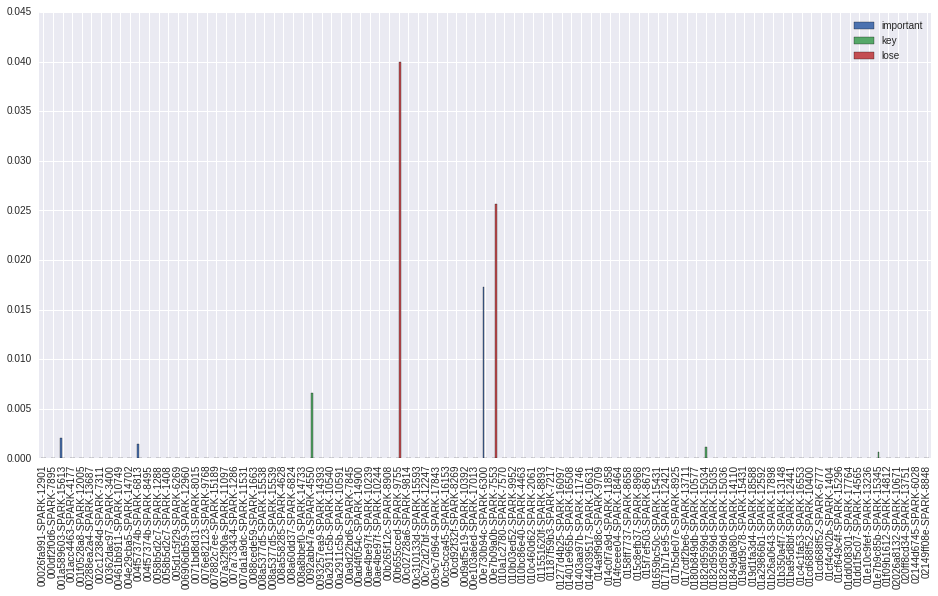

In [232]:
inauguralDf[['important', 'key', 'lose']].plot(kind='bar')

We can even compute, say the ratio of uses of the word "master" to uses of the word "class."

In [233]:
#americaWorldRatio = inauguralDf['master']/inauguralDf['class']
#americaWorldRatio.plot(kind='bar')

### 3.4.  The issues classfication

In [234]:
tfidfOut[0].shape

(1, 3005)

Becuase a word vector is 3005-dimensional, so in order to plot it in 2D, it might help to reduce the dimensionality to the most meaningful dimensions. We can use Scikit-Learn to perform truncated singular value decomposition for latent semantic analysis (LSA).

In [235]:
lsa = TruncatedSVD(n_components=2)
lsaOut = lsa.fit_transform(tfidfOut.todense())

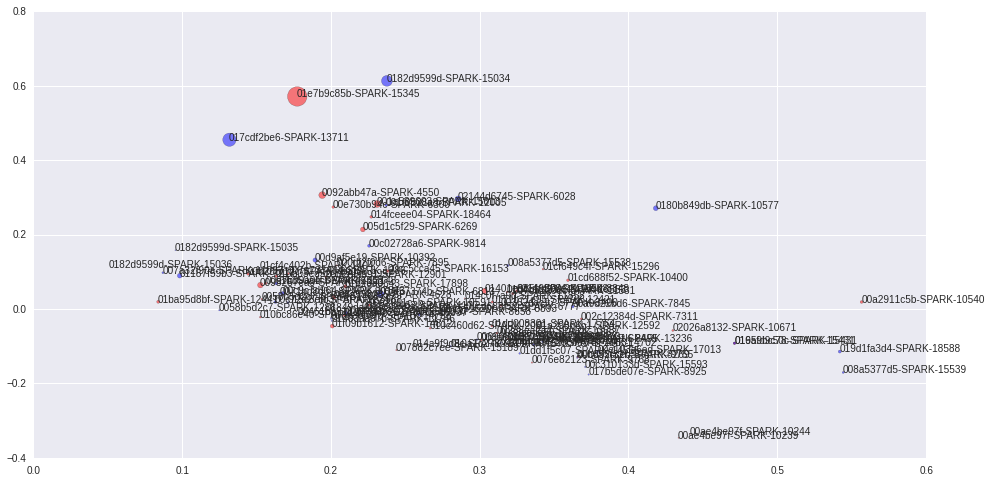

In [236]:
#The classification of all documents
xs, ys = lsaOut[:,0], lsaOut[:,1]
for i in range(len(xs)): 
    plt.scatter(xs[i], ys[i], c=parties[i], s=lengths[i], alpha=0.5)
    plt.annotate(labels[i], (xs[i], ys[i]))

### 3.5.  The document similarity matrix

Using the .similarity() method from earlier that uses word vectors, we can very easily compute the document similarity between all the documents in our corpus.

In [237]:
#　Document Similarity Matrix
similarities = [ [doc.similarity(other) for other in inaugural] for doc in inaugural ]
similaritiesDf = pd.DataFrame(similarities, columns=labels, index=labels)

Both the horizontal axis and the vertical axis show all issues, the deeper the color, the more similar.

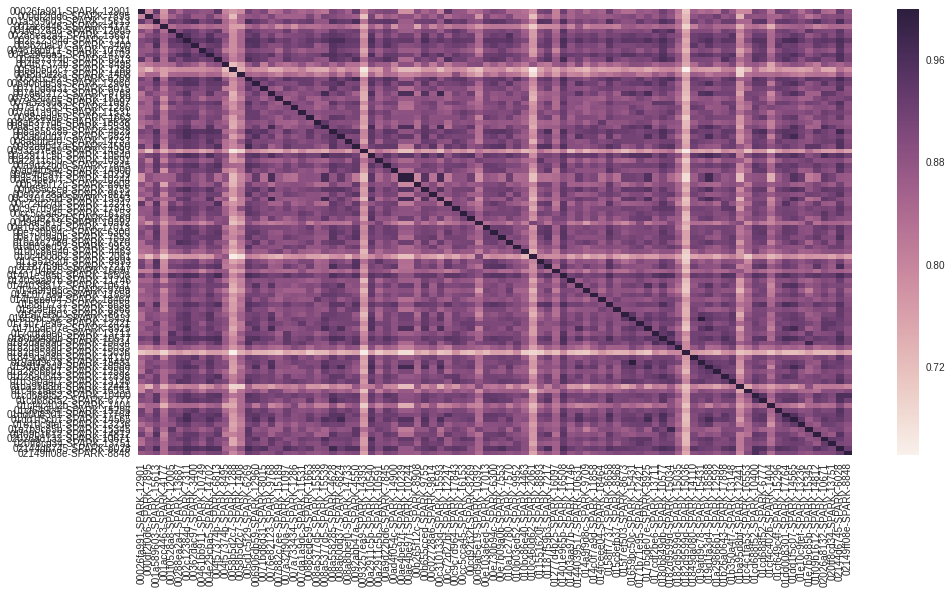

In [238]:
# Requires the Seaborn library. 
rcParams['figure.figsize'] = 16, 8
seaborn.heatmap(similaritiesDf)

In [239]:
# Get the top PROPN words
#firstAdjs = [w for w in first if w.pos_ == 'PROPN']
#Counter([w.string.strip() for w in firstAdjs]).most_common(10)